# Gaussian Process Regression

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=np.inf) # do not wrap lines

## Generate Training and Test Data

X1_mesh.shape: (100, 100)
X1 is [[-3.         -2.93939394 -2.87878788 ...  2.87878788  2.93939394  3.        ]
 [-3.         -2.93939394 -2.87878788 ...  2.87878788  2.93939394  3.        ]
 [-3.         -2.93939394 -2.87878788 ...  2.87878788  2.93939394  3.        ]
 ...
 [-3.         -2.93939394 -2.87878788 ...  2.87878788  2.93939394  3.        ]
 [-3.         -2.93939394 -2.87878788 ...  2.87878788  2.93939394  3.        ]
 [-3.         -2.93939394 -2.87878788 ...  2.87878788  2.93939394  3.        ]]
X2_mesh.shape: (100, 100)
X2 is [[-3.         -3.         -3.         ... -3.         -3.         -3.        ]
 [-2.93939394 -2.93939394 -2.93939394 ... -2.93939394 -2.93939394 -2.93939394]
 [-2.87878788 -2.87878788 -2.87878788 ... -2.87878788 -2.87878788 -2.87878788]
 ...
 [ 2.87878788  2.87878788  2.87878788 ...  2.87878788  2.87878788  2.87878788]
 [ 2.93939394  2.93939394  2.93939394 ...  2.93939394  2.93939394  2.93939394]
 [ 3.          3.          3.         ...  3.          3

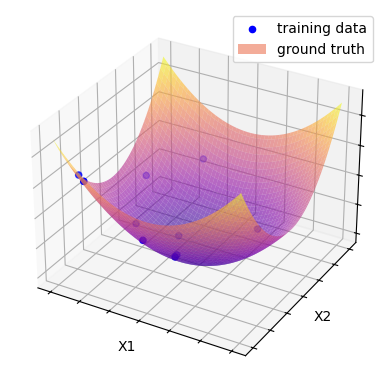

In [5]:
# generate training data and test data for regression

# ground truth function
def ground_truth_func(x1_array: np.ndarray, x2_array: np.ndarray) -> np.ndarray:
    # raise error if x1_array and x2_array have different shape
    # if x1_array.shape != x2_array.shape:
    #     raise ValueError('x1_array and x2_array must have the same shape')
    return 2.0 * x1_array * x1_array + 3.0 * x2_array * x2_array
    # return x1_array * np.exp(-x1_array ** 2 - x2_array ** 2)

    # y = np.zeros((x1_array.shape[0], x2_array.shape[0]))
    # for i, x1 in enumerate(x1_array):
    #     for j, x2 in enumerate(x2_array):
    #         y[i, j] = 2.0 * x1 * x1 + 3.0 * x2 * x2
    # return y

    # return peaks(25) in matlab
    # x1 = x1_array
    # x2 = x2_array
    # y = 3 * (1 - x1) ** 2 * np.exp(-(x1 ** 2) - (x2 + 1) ** 2) - 10 * (x1 / 5 - x1 ** 3 - x2 ** 5) * \
    #     np.exp(-x1 ** 2 - x2 ** 2) - 1 / 3 * np.exp(-(x1 + 1) ** 2 - x2 ** 2)
    # return y

## settings
dim_x = 2 # dimension of input data
min_x1, max_x1 = -3.0, +3.0
min_x2, max_x2 = -3.0, +3.0
train_data_size = 10
test_data_size_x1 = 100 # TODO: bug: data size 50 x 100 does not work
test_data_size_x2 = 100
test_data_size = test_data_size_x1 * test_data_size_x2

## generate data
np.random.seed(1)
X1_train = np.random.uniform(min_x1, max_x1, train_data_size)
X2_train = np.random.uniform(min_x2, max_x2, train_data_size)
y_train = ground_truth_func(X1_train, X2_train)
X1_test = np.linspace(min_x1, max_x1, test_data_size_x1)
X2_test = np.linspace(min_x2, max_x2, test_data_size_x2)
y_test = ground_truth_func(X1_test, X2_test)

# TODO
X_train = np.block([X1_train.reshape(-1, 1), X2_train.reshape(-1, 1)])
X1_test_mesh, X2_test_mesh = np.meshgrid(X1_test, X2_test)
X_test = np.block([X1_test_mesh.reshape(-1, 1), X2_test_mesh.reshape(-1, 1)])

## 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_train, X2_train, y_train, c='blue', marker='o', label='training data')
# # plot surface of ground truth function
X1_mesh, X2_mesh = np.meshgrid(X1_test, X2_test)
print("X1_mesh.shape:", X1_mesh.shape)
print("X1 is", X1_mesh)

print("X2_mesh.shape:", X2_mesh.shape)
print("X2 is", X2_mesh)

Y_mesh = ground_truth_func(X1_mesh, X2_mesh)

print("Y_mesh.shape:", Y_mesh.shape)
print("Y is", Y_mesh)

ax.plot_surface(X1_mesh, X2_mesh, Y_mesh, cmap="plasma", alpha=0.6, label='ground truth')
ax.set_xlabel('X1')
ax.xaxis.labelpad = -8.0
ax.set_ylabel('X2')
ax.yaxis.labelpad = -8.0
ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.legend()
plt.show()

## Define Kernel Function

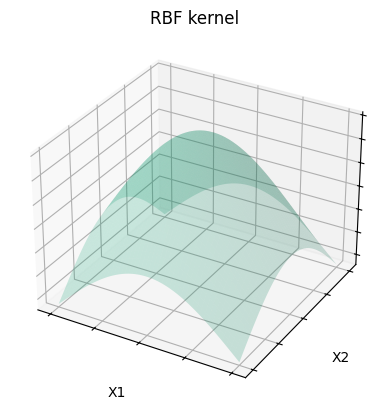

In [6]:
# TODO: use matern kernel
## ref: https://boritaso-blog.com/gaussian_process_regression_kernel/#toc4

# define kernel function
def rbf_kernel(x_i: np.ndarray, x_j: np.ndarray) -> float:
    theta_1 = 1.0
    theta_2 = 2.0
    return theta_1 * np.exp(-1.0 * np.linalg.norm(x_i - x_j, ord=2) ** 2 / theta_2)

# plot kernel function in 3D
x1 = np.linspace(-1.0, 1.0, 100)
x2 = np.linspace(-1.0, 1.0, 100)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)
y_mesh = np.zeros(x1_mesh.shape)
for i in range(x1_mesh.shape[0]):
    for j in range(x1_mesh.shape[1]):
        y_mesh[i, j] = rbf_kernel(np.array([x1_mesh[i, j], x2_mesh[i, j]]), np.array([0.0, 0.0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_mesh, x2_mesh, y_mesh, color="#03AF7A", alpha=0.2)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('RBF kernel')
ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.show()


## Execute Gaussian Process Regression

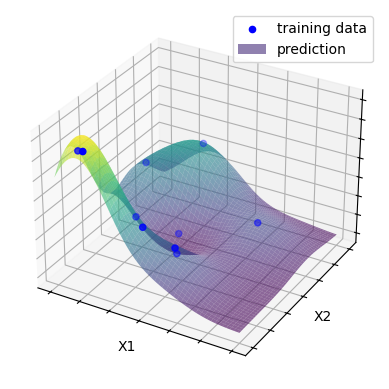

In [7]:
class GaussianProcessRegression:
    def __init__(self, kernel):
        self.kernel = kernel

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        # get matrix size
        train_data_size = X_train.shape[0]
        dim_x = X_train.shape[1]

        # calculate kernel matrix K (train_data_size x train_data_size)
        K = np.zeros((train_data_size, train_data_size))
        for r in range(train_data_size):
            for c in range(train_data_size):
                K[r, c] = self.kernel(X_train[r], X_train[c])

        # calculate expanded kernel matrix K_big (train_data_size x test_data_size)        
        K_big = np.zeros((train_data_size, test_data_size))
        for r in range(train_data_size):
            for c in range(test_data_size):
                K_big[r, c] = self.kernel(X_train[r], X_test[c])

        # calculate mean and variance
        s = self.kernel(X_test, X_test)
        yy = np.linalg.inv(K) @ y_train
        y_pred = K_big.T @ yy
        y_var = s - np.diag(K_big.T @ np.linalg.inv(K) @ K_big)

        return y_pred.reshape(test_data_size_x1, test_data_size_x2), y_var.reshape(-1, dim_x)

    def optimize(self):
        # TODO: optimize hyperparameters automatically
        pass

# instanciate the GPR class
gpr = GaussianProcessRegression(kernel=rbf_kernel)

# fit the model
y_pred, y_var = gpr.fit(X_train, y_train)

# plot the result in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.scatter(X1_train, X2_train, y_train, c='blue', marker='o', zorder=2, label='training data')
# plot surface of gpr prediction
ax.plot_surface(X1_mesh, X2_mesh, y_pred, cmap='viridis', alpha=0.6, zorder=1, label='prediction')
ax.set_xlabel('X1')
ax.xaxis.labelpad = -8.0
ax.set_ylabel('X2')
ax.yaxis.labelpad = -8.0
ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.legend()
plt.show()